# Dataframes
Los **DataFrames** son una parte fundamental de la **API Estructurada de Spark** (*Spark's Structured API*). Esta API permite manipular ficheros desustructurados, semi estructurados (ejemplo: CSV) o ficheros altamente estructurados (Parquet). Se contemplan tres tipos de colecciones distribuídas:
- **Datasets**: Versión más fuertemente tipada de los *DataFrames*. Disponible solamante en lenguajes basados en JVM, como Java o Scala.
- **DataFrames**: Colecciones con forma de tabla, con filas y columnas bien definidas. A diferencia de los *DataSets* el tipado no es tan fuerte y solamente se comprueba en tiempo de ejecución.
- **Tablas y vistas de SQL**: Se pueden crear tablas/vistas a partir de *DataFrames*. La función *spark.sql()* permite realizar consultas SQL directamente sobre ellas.

El proceso que se sigue para ejecutar un trabajo con la API Estructurada de Spark es el siguiente:
1. Escribir el código para manejar DataFrames/DataSets/SQL.
2. Si el código es válido *Spark* lo convierte en un *Plan Lógico*
3. Spark convierte el *Plan Lógico* en un *Plan Físico*, aplicando optimizaciones en el proceso.
4. Spark ejecuta el *Plan Físico*, consistente en operaciones con *RDD's* a bajo nivel a través del clúster.

El *Plan Lógico* representa una serie de transformaciones abstractas sin hacer referencia a *ejecutores* o *drivers*. A partir del *código del usuario* se genera un *Plan lógico sin resolver* que es analizado con la ayuda del *Catálogo*, un repositorio que comprueba que las tablas, columnas, etc. existen de verdad y son correctas dando lugar a un *plan lógico resuelto*. Por último se aplica un proceso de optimización para obtener el *Plan lógico optimizado*.
![Plan lógico](./images/logicalplan.png)
El *Plan físico* (*Plan Spark*) especifica como se ejecutará el plan lógico en el clúster, generando diferentes estrategias y comparándolas en base a un modelo de coste.
![Plan físico](./images/physicalplan.png)
El resultado es una serie de *RDD's* y transformaciones. En definitiva, se transforman consultas sobre DataFrames/Datasets o SQL en transformaciones de *RDD's*


In [1]:

# Inicializamos SparkSession y SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("03-Dataframes") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "hdfs:///spark/logs/history") \
    .config("spark.history.fs.logDirectory", "hdfs:///spark/logs/history") \
    .getOrCreate()

spark.version  # Verifica la versión de Spark

#spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Creación de Dataframes
Se pueden crear Dataframes a partir de diversas fuentes:
### A partir de un RDD
toDF()

In [3]:
df =spark.range(50).toDF("number")
df.show()

[Stage 0:>                                                          (0 + 1) / 1]

+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
|    10|
|    11|
|    12|
|    13|
|    14|
|    15|
|    16|
|    17|
|    18|
|    19|
+------+
only showing top 20 rows



### A partir de un archivo
- json

In [ ]:
df2 = spark.read.json("hdfs:///user/jovyan/data/flight-data/json/2010-summary.json")
df2.show()
df2.printSchema()

- csv:

In [ ]:
df_csv = spark.read.option("header", True).csv('hdfs:///user/jovyan/data/flight-data/csv/2015-summary.csv').coalesce(5)
df_csv.show(10)
df_csv.printSchema()
df_csv.rdd.getNumPartitions()

- parquet

In [ ]:
df_parquet = spark.read.parquet("hdfs:///user/jovyan/data/flight-data/parquet/2010-summary.parquet")
df_parquet.show(10)
df_parquet.printSchema()

### Esquemas
Aunque los *DataFrames no sean tan fuertemente tipados como los *Datasets* sí que se le puede asignar un tipo a cada campo, aunque la comprobación solamente se haga en tiempo de ejecución. Para conocer el esquema de un *DataFrame* podemos usar el método *printSchema*. A este respecto tenemos dos opciones:
- Especificar el esquema:

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Definir el esquema

schema = StructType([

    StructField("InvoiceNo", IntegerType(), True),

    StructField("StockCode", StringType(), True),

    StructField("Description", StringType(), True),

    StructField("Quantity", IntegerType(), True),

    StructField("InvoiceDate", TimestampType(), True),

    StructField("UnitPrice", DoubleType(), True),

    StructField("CustomerID", IntegerType(), True),

    StructField("Country", StringType(), True)

])



# Leer el archivo CSV con el esquema especificado

df = spark.read.csv("hdfs:///user/jovyan/data/retail-data/all/online-retail-dataset.csv", header=True, schema=schema)

df.printSchema()

- Inferir el esquema:

In [ ]:
df_csv = spark.read.option("header", True).option("inferSchema","true").csv('hdfs:///user/jovyan/data/flight-data/csv/2015-summary.csv').coalesce(5)
df_csv.show(10)
df_csv.printSchema()
df_csv.rdd.getNumPartitions()

## Persistencia de datos
A su vez, Spark permite almacenar los datos en diversos tipos de archivos usando los diferentes métodos de *DataFrame.write* (para json *write.json*). Algunas de las opciones son las siguientes:
- *header*: Si queremos almacenar o no la cabecera.
- *mode*: Si queremos sobreescribir o no (para sobreescribir mode=*overwrite*).

NOTA: Debido a problemas de permisos con los volúmenes de Docker, en estos cuadernos deberemos hacerlo fuera del directorio *work*.

In [ ]:

df_csv.write.csv("/user/jovyan/output/datos.csv", header= True, mode="overwrite")
# df_csv.write.json("/home/jovyan/salida/datos.json", mode="overwrite"

## Transformacioness
A continuación vamos a ver algunas de las principales transformaciones permitidas para Dataframes
### select
Permiten hacer una operación equivalente al select de las BBDDR. Dos variantes:
- **select**


In [ ]:
df_csv.select("DEST_COUNTRY_NAME").show(5)

Podemos usar lal función **expr** para diversas acciones, por ejemplo, usar alias

In [ ]:
from pyspark.sql.functions import expr, col, column
df_csv.select(expr("DEST_COUNTRY_NAME AS destination")).show(5)

- **selectExpr**:
Permite añadir expresiones de una forma más sencilla. Podemos hacer operaciones sencillas como usar alias (1) u operaciones más complejas como añadir columnas (2) 

In [ ]:
# 1:
df_csv.selectExpr("DEST_COUNTRY_NAME AS Destino", "ORIGIN_COUNTRY_NAME AS Origen").show(5)
# 2:
df_csv.selectExpr("*", "(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) AS withinCountry").show(5)

### Añadir columnas
Sin embargo, para añadir columnas puede ser más sencillo el método **withColumn**

In [ ]:
df_csv.withColumn("withinCountry", expr("ORIGIN_COUNTRY_NAME = DEST_COUNTRY_NAME")).show(5)

### Renombrar columnas
De la misma forma, **withColumnRenamed** permite usar alias de forma más directa

In [ ]:
df_csv.withColumnRenamed("DEST_COUNTRY_NAME","dest").show(5)

### Eliminar columnas
La función **drop** permite eliminar una columna

In [ ]:
df_csv.drop("ORIGIN_COUNTRY_NAME").show(5)

### Filtrar filas
Las funciones **where/filter** permiten filtrar el DF por un criterio, de forma similar a la cláusula Where de SQL

In [ ]:
df_csv.filter("DEST_COUNTRY_NAME = 'United States' AND count < 5").show(5)

### Obtener filas únicas
La función **distinct** permite eliminar duplicados

In [ ]:
df_csv.select("ORIGIN_COUNTRY_NAME","DEST_COUNTRY_NAME").distinct().show(5)

### Ordenando filas
Con **sort** podemos ordenar el DF en función de la columna especificada. Las funciones **asc** y **desc** nos permiten especificar el sentido de la ordenación (por defecto ascendente)


In [ ]:
df_csv.sort("count").show(5)

In [ ]:
from pyspark.sql.functions import desc, asc
df_csv.sort(col('count').desc(), col('ORIGIN_COUNTRY_NAME').asc()).show(5)

### limit
Permite limitar el número de filas obtenidas.

In [ ]:
df2.limit(5).show()

## Trabajando con particiones
Utilizando el atributo *rdd* de la clase *Dataframe*se pueden utilizar las funciones vistas para la API de RDD's.
### getNumPartitions
Permite obtener el número de particiones de un *DataFrame*

In [ ]:
df2.rdd.getNumPartitions()


### repartition
Permite cambiar el número de particiones, después de *barajar* los datos. Permite varias opciones:
- Indicando sólo el número de particiones deseado

In [ ]:
df2a = df2.rdd.repartition(5)
df2a.rdd.getNumPartitions()

- Indicando la columna por la cual queremos "reparticionar"

In [ ]:
from pyspark.sql.functions import col
df2b= df2.repartition(col("DEST_COUNTRY_NAME"))
df2b.rdd.getNumPartitions()

- Indicando ambas cosas:

In [ ]:
from pyspark.sql.functions import col
df2c = df2.repartition (5, col("DEST_COUNTRY_NAME"))
df2c.rdd.getNumPartitions()

## Agregaciones
Spark permite el uso de diversas funciones de agregación con *Dataframes*. Para ello vamos a usar el siguiente DataFrame:



In [ ]:
df_ag = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("hdfs:///user/jovyan/data/retail-data/all/*.csv")\
  .coalesce(5)
df_ag.cache()
df_ag.createOrReplaceTempView("dfTable")
df_ag.printSchema()
df_ag.show(5)

A continuación, algunas de las más importantes:

### count 
Podemos usarla de tres formas:
- Especificanco una columna
- Especificando todas las columnas (*)
- Contar todas las filas como un literal (1)

In [ ]:
from pyspark.sql.functions import count
df_ag.select(count("InvoiceNo")).show()

df_ag.select(count("*")).show()



### countDistinct: 
Cuenta el número de ocurrencias distintas de una columna

In [ ]:
from pyspark.sql.functions import countDistinct
df_ag.select(countDistinct("InvoiceNo")).show()

### approx_count_distinct
Al trabajar con grandes conjuntos de datos puede interesar una aproximación

In [ ]:
from pyspark.sql.functions import approx_count_distinct
df_ag.select(approx_count_distinct("InvoiceNo",0.1)).show()

### first/last
Permiten obtener el *primero* o el *último* elemento de una columna

In [ ]:
from pyspark.sql.functions import first,last
df_ag.orderBy("Country").select(first("Country"), last("Country")).show()

### min/max
Permiten obtener el valor *máximo* o *mínimo* de una columna.

In [ ]:
from pyspark.sql.functions import max,min
df_ag.select(max("Quantity"),min("Quantity")).show()

### sum, sumDistinct
Mientras que **sum** realiza la suma de todos los elementos de una columna **sum_distinct** hace lo mismo pero eliminando antes los repetidos.

In [ ]:
from pyspark.sql.functions import sum, sum_distinct
df_ag.select(sum("UnitPrice")).show()
df_ag.select(sum_distinct("UnitPrice")).show()

### avg
Realiza la *media aritmética* de los valores de una columna

In [ ]:
from pyspark.sql.functions import avg

df_ag.select(avg("UnitPrice")).show()

### Otros parámetros estadísticos
- varianza y desviación estándar


In [ ]:
from pyspark.sql.functions import var_pop, stddev_pop, var_samp, stddev_samp
# Calculando varianza y desviación estándar sobre el total de la población
df_ag.select(var_pop("Quantity"), stddev_pop("Quantity")).show()

# Calculando varianza y desviación estándar sobre un muestreo de la población
df_ag.select(var_samp("Quantity"), stddev_samp("Quantity")).show()

- oblicuidad y curtosis
- covarianza y correlación 

In [ ]:
from pyspark.sql.functions import skewness, kurtosis
df_ag.select(skewness("Quantity"), kurtosis("Quantity")).show()

from pyspark.sql.functions import corr, covar_pop, covar_samp
df_ag.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),
    covar_pop("InvoiceNo", "Quantity")).show()



### GroupBy
Para realizar los agrupamientos se necesitan dos fases:
- **Agrupar**: Empleamos la función *groupBy* indicando la columna por la que queremos agrupar
- **agregar**: Indicamos la función mediante la cual queremos agregar los resultados (en el ejemplo *count*)

In [ ]:
df_ag.groupBy("InvoiceNo").count().orderBy("count",ascending=False).show()

También podemos agrupar empleando expresiones:

In [ ]:
from pyspark.sql.functions import sum
df_ag.groupBy("InvoiceNo").agg(sum("Quantity").alias("productos totales")).show()

### Agrupamiento con mapeo
A veces puede ser útil expresar las transformaciones como series de *mapeos* en los cuales la *clave* es la columna y el *valor* es una función de agregación.


In [ ]:
from pyspark.sql.functions import expr
df_ag.groupBy("InvoiceNo").agg(expr("avg(Quantity)"), expr("stddev_pop(Quantity)")).show()

## Agregaciones sobre tipos complejos
Spark permite agregar valores no numéricos:
- *collect_list*: Recolecta todos los valores de una determinada columna
- *collect_set*: Recolecta todos los valores únicos de una determinada columna

In [ ]:
from pyspark.sql.functions import collect_set,collect_list
df_ag.agg(collect_set("Country"), collect_list("Country")).show()

# SQL
Desde la versión 2.6 se pueden realizar consultas en SQL sobre los Dataframes empleando la función spark.sql(). Para poder hacerlo es necesario crear una vista temporal con la función createOrReplaceTempView()

In [ ]:
df_csv.createOrReplaceTempView("vuelos")
spark.sql("SELECT * FROM vuelos WHERE count = 1").show(5)

## Exportar a pandas

Podemos pasar un Dataframe de Spark a DataFrame de Pandas empleando el método *toPandas()*. Primero, recordamos como podemos generar un DF con una estructura específica:

In [2]:



#DataFrame API

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Definir el esquema

schema = StructType([

    StructField("InvoiceNo", IntegerType(), True),

    StructField("StockCode", StringType(), True),

    StructField("Description", StringType(), True),

    StructField("Quantity", IntegerType(), True),

    StructField("InvoiceDate", TimestampType(), True),

    StructField("UnitPrice", DoubleType(), True),

    StructField("CustomerID", IntegerType(), True),

    StructField("Country", StringType(), True)

])



# Leer el archivo CSV con el esquema especificado

df_struct = spark.read.csv("hdfs:///user/jovyan/data/retail-data/all/online-retail-dataset.csv", header=True, schema=schema)
df_struct.show(10)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|       NULL|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|       NULL|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|       NULL|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|       NULL|     4.25|     17850|United Kingdom|


 Una vez tengamos el DF preparado, lo convertimos en un DataFrame de Pandas:

In [3]:
df2 = df_struct.groupBy("Country").sum("Quantity")
df2.show()
df2_pandas = df2.toPandas()
display (df2_pandas)

+---------------+-------------+
|        Country|sum(Quantity)|
+---------------+-------------+
|         Sweden|        35637|
|      Singapore|         5234|
|        Germany|       117448|
|            RSA|          352|
|         France|       110480|
|         Greece|         1556|
|        Belgium|        23152|
|        Finland|        10666|
|          Malta|          944|
|    Unspecified|         3300|
|          Italy|         7999|
|           EIRE|       142637|
|         Norway|        19247|
|          Spain|        26824|
|        Denmark|         8188|
|      Hong Kong|         4769|
|         Israel|         4353|
|        Iceland|         2458|
|Channel Islands|         9479|
|            USA|         1034|
+---------------+-------------+
only showing top 20 rows



,Country,sum(Quantity)
0,Sweden,35637
1,Singapore,5234
2,Germany,117448
3,RSA,352
4,France,110480
5,Greece,1556
6,Belgium,23152
7,Finland,10666
8,Malta,944
9,Unspecified,3300


Esto nos puede permitir generar gráficos de forma sencilla:

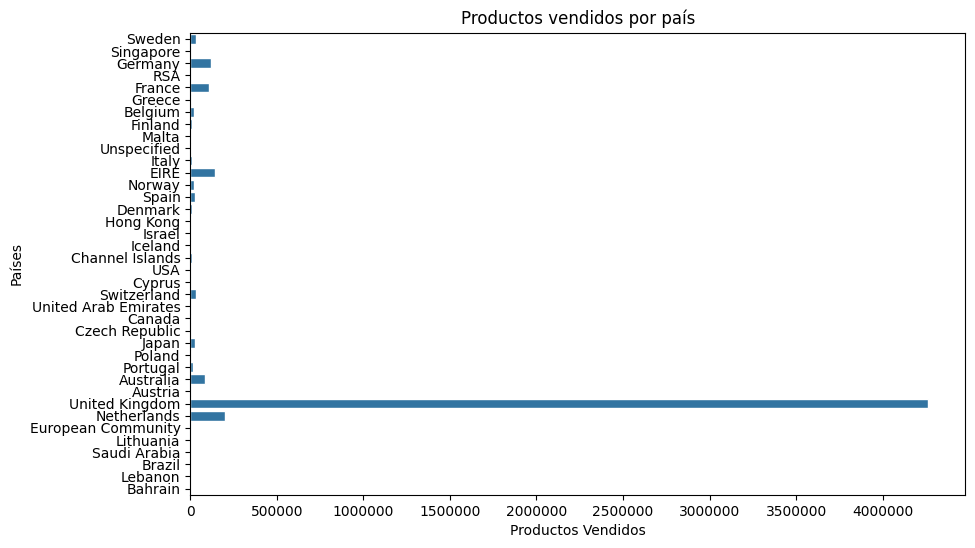

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="sum(Quantity)", y="Country", data=df2_pandas).set_title("Productos vendidos por país")
plt.xlabel("Productos Vendidos")
plt.ylabel("Países")

plt.show()